# Look-ahead sampling

<div class="alert alert-warning">
Note: Due to unresolved problems, at the moment we recommend to use only the established DYN and STAT samplers, but not LA.
</div>

In addition to various static (STAT) and dynamic (DYN) samplers implemented in particular using shared-memory multi-processing and distributed processing via a Redis server, pyABC provides a run-time minimizing so-called "look-ahead" (LA) sampler, which is an extension of DYN that uses free workers at the end of a generation in order to start sampling from the next generation already, based on a preliminary proposal distribution. It is particularly useful in the presence of heterogenous model runtimes, in which case STAT and also DYN may wait for single long-running simulations to finish before continuing with the next generation.

In this notebook, we demonstrate the usage of this method in pyABC. It was run on a machine with 48 cores, using the same number of workers, for a population size of 50. If the notebook is run with a low number of workers (<< population size), advantages of LA do not get structurally apparent. See the corresponding publication for an in-depth analysis on high-performance infrastructure. For typical applications, we observed on average a reduction of the total wall-time of 10%-20% of LA over DYN (and a major reduction of 50% of DYN compared to STAT) when the number of workers roughly equals the population size, with reductions of up to nearly 50% when the number of workers far exceeds the population size.

In [ ]:
# install if not done yet
!pip install pyabc --quiet

In [1]:
import logging
import os
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

import pyabc

# set to "DEBUG" to get full logging information from the sampler and workers
logging.getLogger("ABC.Sampler").setLevel("WARNING")

pyabc.settings.set_figure_params('pyabc')  # for beautified plots

The LA sampler is implemented via Redis. In practice, server and workers need to be started as described in [the documentation](https://pyabc.readthedocs.io/en/latest/sampler.html), e.g. as follows: Start a redis server:

    redis-server --port 6379
 
and connect workers to it via e.g.:

    abc-redis-worker --host=localhost --port=6379 --processes=4 --runtime=2h

For convenience, in this notebook we use an integrated server starter that runs both server and workers locally.

Next, we define a simple ODE based test model (similar to [this notebook](https://pyabc.readthedocs.io/en/latest/examples/conversion_reaction.html)) to perform the parameter inference on. To emulate runtime heterogeneity, which is often observed in practice when e.g. the number of reactions to be simulated is parameter-dependent, we randomly extend each model evaluation time.

In [2]:
theta1_true, theta2_true = np.exp([-2.5, -2])
theta_true = {"theta1": theta1_true, "theta2": theta2_true}
measurement_times = np.arange(11)
init = np.array([1, 0])
sigma = 0.03


def f(y, t0, theta1, theta2):
    x1, x2 = y
    dx1 = -theta1 * x1 + theta2 * x2
    dx2 = theta1 * x1 - theta2 * x2
    return dx1, dx2


def model(pars):
    # numerical integration
    sol = sp.integrate.odeint(
        f, init, measurement_times, args=(pars["theta1"], pars["theta2"])
    )
    # we only observe species 2
    sol = sol[:, 1]

    # add multiplicative measurement noise to ODE solution
    noise = np.random.normal(1, 0.03, size=len(sol))
    noisysol = sol * np.random.normal(1, sigma, size=len(sol))

    # sleep a little to emulate heterogeneous run times
    sleep_s = np.random.lognormal(mean=-2, sigma=1)
    time.sleep(sleep_s)

    return {"X_2": noisysol}


def distance(simulation, data):
    return np.absolute(data["X_2"] - simulation["X_2"]).sum()


measurement_data = model(theta_true)

parameter_prior = pyabc.Distribution(
    theta1=pyabc.RV("uniform", 0, 1), theta2=pyabc.RV("uniform", 0, 1)
)

### Sampling

First, set some run parameters (epsilons, population size etc.)

In [3]:
db_file = f"sqlite:///{os.path.join(tempfile.gettempdir(), 'test.db')}"

# note: this population size is for demonstration purposes,
#  it is far too low for applications
pop_size = 50
eps_list = np.logspace(start=np.log2(8), stop=np.log2(0.5), num=5, base=2)
eps = pyabc.ListEpsilon(eps_list)

# run more often to get average statistics
iters = 3
iters_la = iters
iters_dyn = iters
iters_stat = iters

In practice, the below `RedisEvalParallelSamplerServerStarter` should be replaced by a `RedisEvalParallelSampler` with the correct host IP and port.

Perform sampling using **DYN** scheduling:

In [4]:
redis_sampler = pyabc.sampler.RedisEvalParallelSamplerServerStarter(
    look_ahead=False,
    workers=pyabc.nr_cores_available(),
    # wait_for_all_samples=True,
)
hs_dyn = []

for i in range(0, iters_dyn):
    abc = pyabc.ABCSMC(
        models=model,
        parameter_priors=parameter_prior,
        distance_function=distance,
        population_size=pop_size,
        sampler=redis_sampler,
        eps=eps,
    )

    abc.new(db_file, measurement_data)
    h = abc.run(max_nr_populations=len(eps_list))
    hs_dyn.append(h)

ABC.History INFO: Start <ABCSMC id=1, start_time=2021-06-15 16:13:43>
ABC INFO: t: 0, eps: 8.00000000e+00.
ABC INFO: Accepted: 50 / 92 = 5.4348e-01, ESS: 5.0000e+01.
ABC INFO: t: 1, eps: 4.00000000e+00.
ABC INFO: Accepted: 50 / 101 = 4.9505e-01, ESS: 4.4289e+01.
ABC INFO: t: 2, eps: 2.00000000e+00.
ABC INFO: Accepted: 50 / 124 = 4.0323e-01, ESS: 4.7956e+01.
ABC INFO: t: 3, eps: 1.00000000e+00.
ABC INFO: Accepted: 50 / 133 = 3.7594e-01, ESS: 4.9086e+01.
ABC INFO: t: 4, eps: 5.00000000e-01.
ABC INFO: Accepted: 50 / 386 = 1.2953e-01, ESS: 3.3828e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:19.126282, end_time=2021-06-15 16:14:02>
ABC.History INFO: Start <ABCSMC id=2, start_time=2021-06-15 16:14:02>
ABC INFO: t: 0, eps: 8.00000000e+00.
ABC INFO: Accepted: 50 / 77 = 6.4935e-01, ESS: 5.0000e+01.
ABC INFO: t: 1, eps: 4.00000000e+00.
ABC INFO: Accepted: 50 / 94 = 5.3191e-01, ESS: 4.4829e+01.
ABC INFO: t: 2, eps: 2.00000000e+00.
ABC INFO

Note that the dynamical Redis sampler also has an option `wait_for_all_particles=False`, which was newly introduced in version 0.10.15 and already speeds things up by keeping track of which simulations need to be waited for exactly. The previous implementation is equivalent to `False`, in which case all started samples are waited for, including ones that were started after the last accepted one and are thus disregarded anyway.

Perform sampling using **LA** scheduling:

In [5]:
hs_la = []
sampler_logfiles = []
for i in range(0, iters_la):
    logfile = tempfile.mkstemp(prefix="redis_log", suffix=".csv")[1]
    sampler_logfiles.append(logfile)
    redis_sampler = pyabc.sampler.RedisEvalParallelSamplerServerStarter(
        # main field: in generation t already preemptively sample for t+1 if cores
        #  are available
        look_ahead=True,
        # whether to delay evaluation until the next generation has really
        #  started, this is necessary if any component s.a. eps, distance is
        #  adaptive
        look_ahead_delay_evaluation=True,
        # determines how many samples to sample preemptively maximally without
        #  checking
        max_n_eval_look_ahead_factor=2,
        # a file for some sampler debugging output
        log_file=logfile,
        workers=pyabc.nr_cores_available(),
    )

    abc = pyabc.ABCSMC(
        models=model,
        parameter_priors=parameter_prior,
        distance_function=distance,
        population_size=pop_size,
        sampler=redis_sampler,
        eps=eps,
    )

    abc.new(db_file, measurement_data)
    h = abc.run(max_nr_populations=len(eps_list))
    hs_la.append(h)

ABC.History INFO: Start <ABCSMC id=4, start_time=2021-06-15 16:14:36>
ABC INFO: t: 0, eps: 8.00000000e+00.
ABC INFO: Accepted: 50 / 83 = 6.0241e-01, ESS: 5.0000e+01.
ABC INFO: t: 1, eps: 4.00000000e+00.
ABC INFO: Accepted: 50 / 94 = 5.3191e-01, ESS: 4.5765e+01.
ABC INFO: t: 2, eps: 2.00000000e+00.
ABC INFO: Accepted: 50 / 129 = 3.8760e-01, ESS: 4.5808e+01.
ABC INFO: t: 3, eps: 1.00000000e+00.
ABC INFO: Accepted: 50 / 145 = 3.4483e-01, ESS: 4.9157e+01.
ABC INFO: t: 4, eps: 5.00000000e-01.
ABC INFO: Stop: Maximum number of generations.
ABC INFO: Accepted: 50 / 514 = 9.7276e-02, ESS: 4.6039e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=4, duration=0:00:11.453524, end_time=2021-06-15 16:14:47>
ABC.History INFO: Start <ABCSMC id=5, start_time=2021-06-15 16:14:49>
ABC INFO: t: 0, eps: 8.00000000e+00.
ABC INFO: Accepted: 50 / 82 = 6.0976e-01, ESS: 5.0000e+01.
ABC INFO: t: 1, eps: 4.00000000e+00.
ABC INFO: Accepted: 50 / 93 = 5.3763e-01, ESS: 2.8616e+01.

The LA sampler uses a preliminary proposal distribution based on the last generation's preliminarily accepted particles, to start sampling for the next generation as soon as workers become idle. When the last generation is actually done, the proposal is updated and continued with. The accepted population can then consist of accepted particles from both preliminary and actual proposals, which are in pyABC weighted in order to maximize the overall effective sample size.

If the problem possesses a highly skewed parameter-runtime structure (e.g. with fast runtimes in one regime, slow ones in another), then theoretically LA can lead to fast estimates that are however biased towards that fast regime, because the preliminary proposal distribution may be biased. In practical applications, we have observed similarly stable posterior approximations with all of STAT, DYN, LA, i.e. no such problem, but one may want to keep this in mind.

Perform sampling using **STAT** scheduling, which is known to be less efficient than DYN for large numbers of workers, but may be competitive for few (see e.g. [the publication](https://doi.org/10.1093/bioinformatics/bty361)):

In [6]:
redis_sampler = pyabc.sampler.RedisStaticSamplerServerStarter(
    workers=pyabc.nr_cores_available(),
)

hs_stat = []

for i in range(0, iters_stat):
    abc = pyabc.ABCSMC(
        models=model,
        parameter_priors=parameter_prior,
        distance_function=distance,
        population_size=pop_size,
        sampler=redis_sampler,
        eps=eps,
    )

    abc.new(db_file, measurement_data)
    h = abc.run(max_nr_populations=len(eps_list))
    hs_stat.append(h)

ABC.History INFO: Start <ABCSMC id=7, start_time=2021-06-15 16:15:15>
ABC INFO: t: 0, eps: 8.00000000e+00.
ABC INFO: Accepted: 50 / 50 = 1.0000e+00, ESS: 5.0000e+01.
ABC INFO: t: 1, eps: 4.00000000e+00.
ABC INFO: Accepted: 50 / 58 = 8.6207e-01, ESS: 4.1230e+01.
ABC INFO: t: 2, eps: 2.00000000e+00.
ABC INFO: Accepted: 50 / 91 = 5.4945e-01, ESS: 4.7137e+01.
ABC INFO: t: 3, eps: 1.00000000e+00.
ABC INFO: Accepted: 50 / 115 = 4.3478e-01, ESS: 4.9054e+01.
ABC INFO: t: 4, eps: 5.00000000e-01.
ABC INFO: Accepted: 50 / 224 = 2.2321e-01, ESS: 4.5663e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=7, duration=0:00:15.767970, end_time=2021-06-15 16:15:31>
ABC.History INFO: Start <ABCSMC id=8, start_time=2021-06-15 16:15:31>
ABC INFO: t: 0, eps: 8.00000000e+00.
ABC INFO: Accepted: 50 / 50 = 1.0000e+00, ESS: 5.0000e+01.
ABC INFO: t: 1, eps: 4.00000000e+00.
ABC INFO: Accepted: 50 / 63 = 7.9365e-01, ESS: 3.1889e+01.
ABC INFO: t: 2, eps: 2.00000000e+00.
ABC INFO: 

### Results

The posterior distributions of all samplers should look similar for large enough population sizes. Given the low population size used here, there is considerable stochasticity. For application runs, the population size should be considerably higher.

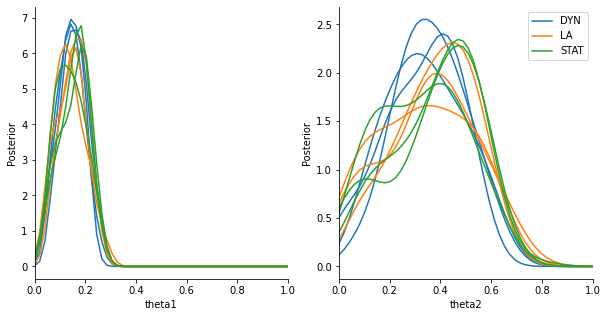

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i_h, h in enumerate(hs_dyn):
    df, w = h.get_distribution(m=0, t=h.max_t)
    for par, ax in zip(["theta1", "theta2"], axes):
        pyabc.visualization.plot_kde_1d(
            df,
            w,
            x=par,
            ax=ax,
            color="C0",
            xmin=0,
            xmax=1,
            label="DYN" if i_h == 0 else None,
        )

for i_h, h in enumerate(hs_la):
    df, w = h.get_distribution(m=0, t=h.max_t)
    for par, ax in zip(["theta1", "theta2"], axes):
        pyabc.visualization.plot_kde_1d(
            df,
            w,
            x=par,
            ax=ax,
            color="C1",
            xmin=0,
            xmax=1,
            label="LA" if i_h == 0 else None,
        )

for i_h, h in enumerate(hs_stat):
    df, w = h.get_distribution(m=0, t=h.max_t)
    for par, ax in zip(["theta1", "theta2"], axes):
        pyabc.visualization.plot_kde_1d(
            df,
            w,
            x=par,
            ax=ax,
            color="C2",
            xmin=0,
            xmax=1,
            label="STAT" if i_h == 0 else None,
        )

plt.legend()

LA generally minimizes the overall wall-time, as all cores are used at almost all times.
The effect becomes more apparent when working on large-scale infrastructure with dozens or hundreds of workers.

Epsilon over wall-time (for typical applications one would expect this to be lowest for LA and highest for STAT):

<AxesSubplot:title={'center':'Epsilon over walltime'}, xlabel='Time [s]', ylabel='Epsilon'>

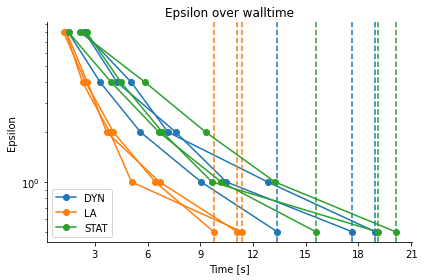

In [8]:
hs = [*hs_dyn, *hs_la, *hs_stat]
labels = [
    *["DYN"] * len(hs_dyn),
    *["LA"] * len(hs_la),
    *["STAT"] * len(hs_stat),
]

pyabc.visualization.plot_eps_walltime(hs, labels, group_by_label=True)

# for separate plotting
# pyabc.visualization.plot_eps_walltime(hs[:iters], labels[:iters])
# pyabc.visualization.plot_eps_walltime(hs[iters:2*iters], labels[iters:2*iters])
# pyabc.visualization.plot_eps_walltime(hs[2*iters:], labels[2*iters:])

<AxesSubplot:title={'center':'Total walltimes'}, xlabel='Run', ylabel='Time [s]'>

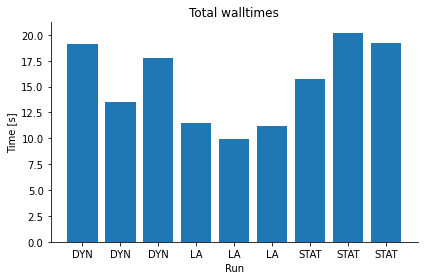

In [9]:
pyabc.visualization.plot_total_walltime(hs, labels)

Total number of samples (for typical applications one would expect this to be lowest for STAT and highest for LA):

<AxesSubplot:title={'center':'Total required samples'}, xlabel='Run', ylabel='Total samples'>

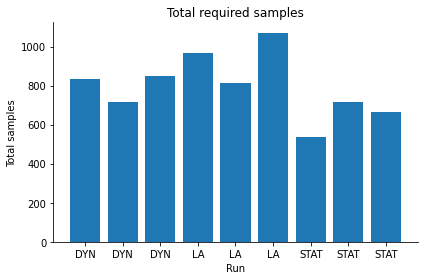

In [10]:
pyabc.visualization.plot_total_sample_numbers(hs, labels)

Let us investigate the behavior of the look-ahead sampler in a bit more detail, the number of samples generated in look-ahead mode, and the composition of the final accepted sample.

Depending on the problem structure, this can look different. It can be that most or all samples of a generation are from look-ahead mode if the acceptance rate is high and there are some very long-running simulations, while it will typically be a lower percentage if the acceptance rate is lower (in later generations) or the simulation times are more homogeneous.

Number of look-ahead and actual (=with the final proposal) samples:

<AxesSubplot:title={'center':'Total evaluations'}, xlabel='Population index', ylabel='Evaluations'>

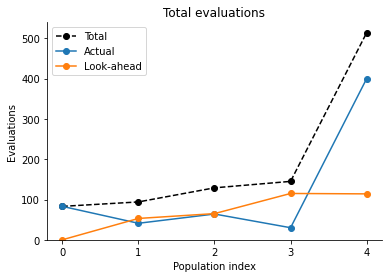

In [11]:
pyabc.visualization.plot_lookahead_evaluations(
    sampler_df=sampler_logfiles[0],
    # relative=True,
)

Composition of final accepted population:

<AxesSubplot:title={'center':'Composition of final acceptances'}, xlabel='Population index', ylabel='Final acceptances'>

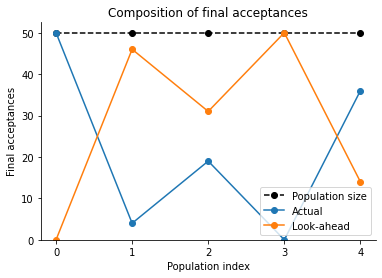

In [12]:
pyabc.visualization.plot_lookahead_final_acceptance_fractions(
    sampler_logfiles[0],
    hs_la[0],
    # relative=True,
)

Acceptance rates in look-ahead and actual mode:

<AxesSubplot:title={'center':'Acceptance rates'}, xlabel='Population index', ylabel='Acceptance rate'>

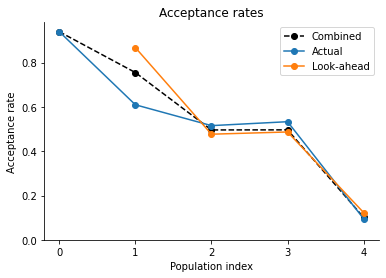

In [13]:
pyabc.visualization.plot_lookahead_acceptance_rates(
    sampler_df=sampler_logfiles[0]
)

For details on the use and options of the various samplers, see the [API documentation](https://pyabc.readthedocs.io/en/latest/api_sampler.html). Note that unlike STAT and DYN, LA is currently only implemented via Redis, but e.g. not for multi-processing, which typically does not scale beyond a few dozen workers.